<a href="https://colab.research.google.com/github/abishekP101/Pytorch/blob/main/transfer_learning_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abishek11prasad
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.04GB/s]

In [3]:
import torch
from torch import nn
from torch.optim import Adam , SGD
from torchvision.transforms import transforms
import pandas as pd
from torch.utils.data import Dataset , DataLoader
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
device

'cuda'

In [6]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")


train_df['image:FILE'] = "/content/bean-leaf-lesions-classification/" + train_df['image:FILE']
val_df['image:FILE'] = "/content/bean-leaf-lesions-classification/" + val_df['image:FILE']

In [7]:
train_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [8]:
train_df['image:FILE'][0]

'/content/bean-leaf-lesions-classification/train/healthy/healthy_train.98.jpg'

In [9]:
train_df['category'].value_counts()

,count
category,
2,348
1,345
0,341


In [10]:
train_df.shape , val_df.shape

((1034, 2), (133, 2))

In [11]:
transform = transforms.Compose([
    transforms.Resize((128 ,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [12]:
class CustomImageDataset(Dataset):
  def __init__(self , df , transform = None):
    self.df = df
    self.transform = transform
    self.labels = torch.tensor(df['category'].values).to(device)

  def __len__(self):
    return len(self.df)


  def __getitem__(self , idx):
    img_path = self.df.iloc[idx , 0]
    label = self.labels[idx]
    iamge = Image.open(img_path)
    if self.transform:
      iamge = (self.transform(iamge)/255.0).to(device)
    return iamge , label



In [13]:
train_dataset = CustomImageDataset(train_df , transform)
val_dataset = CustomImageDataset(val_df , transform)

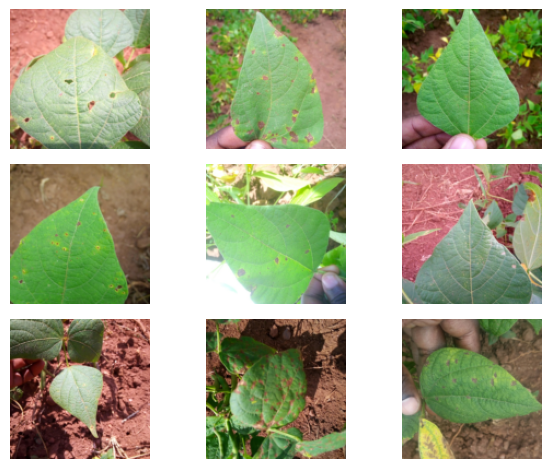

In [14]:
n_rows = 3
n_cols = 3

f , axarr = plt.subplots(n_rows , n_cols)
for row in range(n_rows):
  for col in range(n_cols):
    image = train_dataset[np.random.randint(0 , train_dataset.__len__())][0].cpu()
    axarr[row , col].imshow((image*255.0).squeeze().permute(1 , 2 , 0))
    axarr[row , col].axis('off')
plt.tight_layout()
plt.show()

In [15]:
learning_rate = 1e-3
Batch_size = 32
epochs = 15

In [16]:
train_loader = DataLoader(train_dataset , batch_size = Batch_size , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size = Batch_size , shuffle = False)

In [17]:
googlenet_model  = models.googlenet(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 158MB/s]


In [28]:
for param in googlenet_model.parameters():
  param.requires_grad = True


In [19]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [20]:
num_classes = len(train_df['category'].unique())

In [21]:
googlenet_model.fc = torch.nn.Linear(in_features=1024 , out_features=num_classes)

In [22]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [25]:
criterion = nn.CrossEntropyLoss()
optimizers = Adam(googlenet_model.parameters() , lr = learning_rate)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(epochs):
  total_train_acc = 0
  total_loss_train = 0

  for inputs , labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = googlenet_model(inputs)
    loss = criterion(outputs , labels)
    total_loss_train += loss.item()
    optimizers.zero_grad()
    loss.backward()

    train_acc = (torch.argmax(outputs , axis =1) == labels).sum().item()
    total_train_acc += train_acc
    optimizers.step()

  total_loss_train_plot.append(round(total_loss_train/1000 , 4))
  total_acc_train_plot.append(round(total_train_acc/train_dataset.__len__()*100 , 4))
  print(f"Epoch {epoch+1}/{epochs} , Loss : {round(total_loss_train/1000 , 4)} , Accuracy : {round(total_train_acc/train_dataset.__len__()*100 , 4)}")


Epoch 1/15 , Loss : 0.0224 , Accuracy : 68.8588
Epoch 2/15 , Loss : 0.0152 , Accuracy : 81.1412
Epoch 3/15 , Loss : 0.0129 , Accuracy : 84.236
Epoch 4/15 , Loss : 0.0085 , Accuracy : 89.6518
Epoch 5/15 , Loss : 0.0086 , Accuracy : 88.7814
Epoch 6/15 , Loss : 0.0074 , Accuracy : 91.5861
Epoch 7/15 , Loss : 0.0079 , Accuracy : 91.1025
Epoch 8/15 , Loss : 0.0082 , Accuracy : 91.3926
Epoch 9/15 , Loss : 0.0075 , Accuracy : 91.3926
Epoch 10/15 , Loss : 0.0044 , Accuracy : 94.7776
Epoch 11/15 , Loss : 0.0051 , Accuracy : 94.8743
Epoch 12/15 , Loss : 0.0063 , Accuracy : 91.5861
Epoch 13/15 , Loss : 0.0038 , Accuracy : 95.2611
Epoch 14/15 , Loss : 0.0034 , Accuracy : 96.6151
Epoch 15/15 , Loss : 0.0018 , Accuracy : 98.0658


In [26]:
with torch.no_grad():
  total_test_acc = 0
  total_loss_test = 0

  for inputs , labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    pred = googlenet_model(inputs)
    test_acc = (torch.argmax(pred , axis =1) == labels).sum().item()
    total_test_acc += test_acc

In [27]:
print(round(total_test_acc/val_dataset.__len__()*100 , 2))

54.14


## Transfer Learning

In [30]:
googlenet_model  = models.googlenet(weights='DEFAULT')

for param in googlenet_model.parameters():
  param.requires_grad = False

googlenet_model.fc = torch.nn.Linear(in_features=1024 , out_features=len(train_df['category'].unique()))
googlenet_model.to(device)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [31]:
criterion = nn.CrossEntropyLoss()
optimizers = SGD(googlenet_model.parameters() , lr = learning_rate)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(epochs):
  total_train_acc = 0
  total_loss_train = 0

  for inputs , labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = googlenet_model(inputs)
    loss = criterion(outputs , labels)
    total_loss_train += loss.item()
    optimizers.zero_grad()
    loss.backward()

    train_acc = (torch.argmax(outputs , axis =1) == labels).sum().item()
    total_train_acc += train_acc
    optimizers.step()

  total_loss_train_plot.append(round(total_loss_train/1000 , 4))
  total_acc_train_plot.append(round(total_train_acc/train_dataset.__len__()*100 , 4))
  print(f"Epoch {epoch+1}/{epochs} , Loss : {round(total_loss_train/1000 , 4)} , Accuracy : {round(total_train_acc/train_dataset.__len__()*100 , 4)}")


Epoch 1/15 , Loss : 0.0369 , Accuracy : 34.1393
Epoch 2/15 , Loss : 0.0361 , Accuracy : 36.7505
Epoch 3/15 , Loss : 0.0354 , Accuracy : 43.2302
Epoch 4/15 , Loss : 0.0345 , Accuracy : 43.7137
Epoch 5/15 , Loss : 0.0345 , Accuracy : 46.9052
Epoch 6/15 , Loss : 0.0338 , Accuracy : 50.2901
Epoch 7/15 , Loss : 0.0334 , Accuracy : 52.4178
Epoch 8/15 , Loss : 0.0329 , Accuracy : 53.2882
Epoch 9/15 , Loss : 0.0322 , Accuracy : 56.2863
Epoch 10/15 , Loss : 0.0317 , Accuracy : 58.0271
Epoch 11/15 , Loss : 0.0316 , Accuracy : 57.2534
Epoch 12/15 , Loss : 0.0312 , Accuracy : 57.9304
Epoch 13/15 , Loss : 0.031 , Accuracy : 58.8008
Epoch 14/15 , Loss : 0.0306 , Accuracy : 62.089
Epoch 15/15 , Loss : 0.0304 , Accuracy : 61.0251


In [32]:
with torch.no_grad():
  total_test_acc = 0
  total_loss_test = 0

  for inputs , labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    pred = googlenet_model(inputs)
    test_acc = (torch.argmax(pred , axis =1) == labels).sum().item()
    total_test_acc += test_acc

In [33]:
print(round(total_test_acc/val_dataset.__len__()*100 , 2))

46.62
